# Advanced ML methods notebook

*Authors: Enze Chen and Mark Asta (University of California, Berkeley)*

```{note}
This is an interactive exercise, so you will want to click the {fa}`rocket` and open the notebook in DataHub (or Colab for non-UCB students).
```

## Learning objectives

This notebook contains a series of exercises that explore some advanced ML models that we didn't have enough time to cover during the live session.
While it isn't required that you use these methods in your research, they could give some interesting results.
By the end of this notebook, you should be able to:
1. Build decision trees and articulate their strengths and weaknesses.
1. Build random forests and artibulate their strengths and weaknesses.
1. Evaluate when unsupervised learning is useful and how to perform $k$-means clustering.
1. Define dimensionality reduction and articulate why/when it's useful.

We will rely on the [scikit-learn](https://scikit-learn.org/stable/) package for implementing these algorithms.

<div class="alert alert-block alert-warning">
We have tried our best to present the following material in a visual, intuitive, and applied manner, but as these are more advanced methods, there may be several concepts that are new to you. 
Please don't be concerned if something doesn't make sense right away, and know that we're always happy to answer your questions!
</div>



## Contents

These exercises are grouped into the following sections:

1. [Decision trees](#Decision-trees)
1. [Random forests](#Random-forests)
1. [Unsupervised learning](#Unsupervised-learning)
1. [$k$-means clustering](#$k$-means-clustering)
1. [Dimensionality reduction](#Dimensionality-reduction)

### Import the common packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

plt.rcParams.update({'figure.figsize':(8,6),       # Increase figure size
                     'font.size':20,               # Increase font size
                     'mathtext.fontset':'cm',      # Change math font to Computer Modern
                     'mathtext.rm':'serif',        # Documentation recommended follow-up
                     'lines.linewidth':5,          # Thicker plot lines
                     'lines.markersize':12,        # Larger plot points
                     'axes.linewidth':2,           # Thicker axes lines (but not too thick)
                     'xtick.major.size':8,         # Make the x-ticks longer (our plot is larger!)
                     'xtick.major.width':2,        # Make the x-ticks wider
                     'ytick.major.size':8,         # Ditto for y-ticks
                     'ytick.major.width':2,        # Ditto for y-ticks
                     'xtick.direction':'in', 
                     'ytick.direction':'in'})

## Decision trees

[Back to top](#Contents)

A decision tree is a **nonlinear** model that uses sequence of conditional statements about the input features to make a final prediction.
The resulting model resembles a flowchart and is similar to how humans might make decisions, such as:

![decision tree class](../../assets/fig/07/decision_tree_class.png)

_Note that the above is only an illustration and we do not advocate skipping class_. 😜

In any case, you'll note that the decision tree starts at the **root node** and there is a binary **split** at each decision node (blue ellipses) in the tree. 
The **features** used to make the decisions _can repeat_ (they do not in this example), and it can be a categorical feature (some class or binary, like the `is it recorded?` node) _or_ a numerical feature (some threshold, like the `when did I sleep?` node).
The final decision is made at the **leaf nodes**, which are colored orange and green in the above example.

**Pause and reflect**: Is the above decision tree used to solve a classification or a regression problem?



### Benefits of decision trees

There are several nice aspects to using decision trees, including:
- Works for **classification and regression problems** (discussed more below).
- Works with **categorical and numerical features** (discussed above).
- **Easy to interpret** the model and how predictions are being made.
- **Highly flexible** in how splits (decisions) are made.
- Features **don't need to be standardized**.

### Training a decision tree

Training a decision tree is a little complicated so we won't delve into the details, but as you might imagine, the cost function for regression trees can be our familiar mean squared error.
However, this cost function is now _local_ and re-evaluated at each decision node, so the decision tree construction is a **greedy** procedure.
For classification tasks, the cost function changes to a different metric, common ones being the [Gini impurity](https://victorzhou.com/blog/gini-impurity/) or the [information gain (entropy)](https://victorzhou.com/blog/information-gain/).
Notably, based on the cost function, the algorithm **learns the best feature** to split on at each node for the "optimal split" based on the training data; the user does not specify exactly which feature to consider.
The user does have to supply an input design matrix and an output target vector, which makes a decision tree a **supervised learning** algorithm.

### Decision trees in scikit-learn

OK, now that we have a little bit of the theory under our belts, let's jump into building decision trees.
The [`sklearn.tree`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) module contains the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classes.

You may notice that these constructors have quite a lot of input arguments, which gives us our first experience working with **hyperparameters**. 
Recall that our model _parameters_ ($\vec{\theta}$ in linear regression, or the splitting criteria from above) are _learned from the data_ through an optimization procedure.
Hyperparameters, on the other hand, are _chosen by the user_ and typically _optimized using a cross-validation procedure_ where we search through a list of candidate values for each hyperparameter and pick the best one based on the validation error.
This is called **hyperparameter optimization** and is really important to building a good ML model.

One such hyperparameter we might choose is the `max_depth` which determines how many layers our tree will have (the scikit-learn default is as many as necessary).
In the example below, we will return to the atomic weight regression problem with the atomic number as the single, numerical feature, and you can see how changing `max_depth` changes the model performance.

The following code looks a little complicated because we tried to use [widgets](https://ipywidgets.readthedocs.io/en/latest/) to make it interactive, but note how the first two code blocks in the `train_and_plot()` function are **very similar** to the `LinearRegression` model in scikit-learn.
This design is intentional and makes it very straightforward to experiment with different ML models!

In [2]:
from sklearn.tree import DecisionTreeRegressor       # ML model
from ipywidgets import interact, IntSlider, Layout   # cool package for interactivity

df = pd.read_csv('../../assets/data/elem_props.csv')
X = df[['atomic_number']]
y = df['atomic_mass']

def train_and_plot(depth):
    dt = DecisionTreeRegressor(max_depth=depth)      # decision tree constructor
    dt.fit(X, y)                                     # fit the tree
    y_hat = dt.predict(X)                            # make predictions
    train_err = mean_squared_error(y_hat, y, squared=False)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    y_pred = cross_val_predict(dt, X, y, cv=kfold)
    val_err = mean_squared_error(y_pred, y, squared=False)
    
    fig, ax = plt.subplots()
    ax.scatter(X, y, label='data')
    ax.plot(X, y_hat, 'k', label='predictions')
    ax.text(1, 235, f'training RMSE: {train_err:.3f}')
    ax.text(1, 210, f'validation RMSE: {val_err:.3f}')
    ax.set(xlabel='atomic number', ylabel='atomic mass')
    ax.legend(loc='lower right')
    plt.show()
    
depth_widget = IntSlider(value=1, min=1, max=8, step=1,
                         description='Maximum tree depth',
                         style={'description_width':'150px'}, continuous_update=True,
                         layout=Layout(width='400px', height='30px'))

interact(train_and_plot, depth=depth_widget);

interactive(children=(IntSlider(value=1, description='Maximum tree depth', layout=Layout(height='30px', width=…

**Pause and reflect**: Why is the prediction line so jagged?

**Answer**: After the maximum depth has been reached, it will only predict the mean of the remaining training points in that leaf node.

----

Hopefully you saw that by increasing the `max_depth` of the decision tree, we can get better and better fits to our training data, eventually decreasing the _training error_ all the way down to 0!

**Pause and reflect**: What drawback of decision trees does this behavior suggest?

<!-- solution-begin -->
**Answer**: High variance! Decision trees are _extremely sensitive_ to the input data.
<!-- solution-begin -->

### Visualizing a decision tree

Similar to our very first example where we visualized our "decision tree" for attending class, we can programmatically create visualizations of our decision tree models using the [`plot_tree(decision_tree)`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function in the `sklearn.tree` module.
This is relatively new function that is quite customizable, giving us the option to specify the feature labels and class labels.
We demonstrate it below for the classification problem of a metallic element.

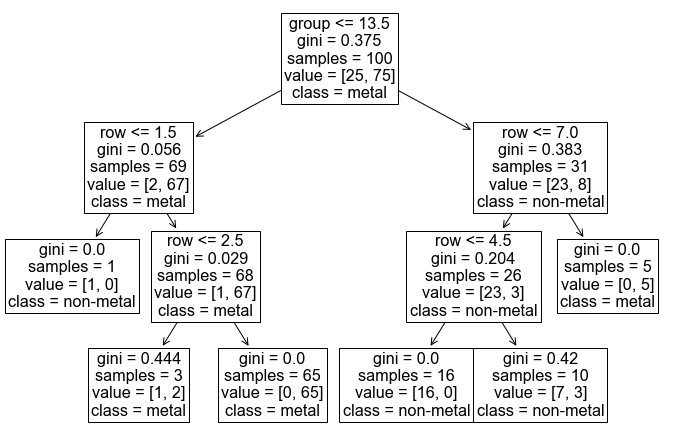

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

df = pd.read_csv('../../assets/data/elem_props.csv')
features = ['row', 'group']
X = df[features]
y = df['is_metal']

dt = DecisionTreeClassifier(random_state=0, max_depth=3)
dt.fit(X, y)

fig, ax = plt.subplots(figsize=(12,8))
plot_tree(dt, feature_names=features, class_names=['non-metal', 'metal'])
plt.show()

Now you can see exactly how the tree made each decision for classifying whether a material was a metal or non-metal.
For example, it makes sense that the first split is vertical between groups 13 and 14, where if the group number is 13 or less, we proceed down a "metal" branch.
The leaf nodes are those without arrows underneath, and the class label that's shown is the label that will be predicted if a material lands on that leaf as a result of traversing the tree.
Notice that features can be repeated, even in successive layers of the tree.
**Hooray for interpretability**!

## Random forests

[Back to top](#Contents)

We hope that you've enjoyed the presentation on decision trees.
It's a cool, intuitive, and interpretable ML algorithm that's good to know.
And it makes for some pretty visuals. 🙂

But there is one _huge problem_ with decision trees and that is their **high variance**.
As you saw, decision trees are capable of partitioning the training data in a very intricate way, which means that the decision tree is very sensitive to noise/error in the training data, which can often lead to **overfitting** or simply inaccuracies.
Once again, it seems like we're at the mercy of the **bias-variance tradeoff** (ha!), where we're either going to end up with large errors due to high-bias/low-complexity models (like linear regression and logistic regression) or high-variance/high-complexity models (like decision trees, or neural networks).
There are ways of improving the performance of decision trees using hyperparameter optimization or _pruning_ (eliminating branches of the tree), but _it would be great if there was an algorithm that could land us at the sweet spot without too much hand tuning_.

### Motivation

Luckily for us, there _is_ such an algorithm, which we will try to motivate in this section.

**Idea 1**: Because we're proud of democracy, we might consider an algorithm that trains not one, not two, but _many_ decision trees and then have them "vote" on the final prediction.
By "vote," we mean we take the _mode_ of the predictions from every decision tree if it's a _classification_ task, and the _mean_ of the predictions from every decision tree if it's a _regression_ problem.
In other words, we are **aggregating** the outputs and performance of an **ensemble** of decision trees—two heads are better than one.

**Idea 2**: But wait!
If we use the same training data for training each decision tree in this ensemble model, we're actually going to end up with pretty similar (**correlated**) trees... which means we'll perform the same as using just one decision tree.
How can we inject some variation... maybe with some randomness?
Let's **bootstrap** the training data, which means from the $m$ data points in our whole training dataset, we will **randomly sample with replacement** $m$ examples to form the training dataset for decision tree #1, randomly sample a different set of $m$ examples for training decision tree #2, etc.

**Idea 3**: The fun doesn't have to stop there.
We know that when we have a lot of features (degrees of freedom), we increase the model complexity and run the risk of overfitting to the training data.
So, maybe when we're deciding which feature to split on at each node, we can just consider **a subset of the features** instead of all the features.
This subset can be a randomly-sampled portion (w/o replacement is fine) of the features at each decision node in every decision tree.
This further decorrelates the decision trees and decreases the variance of the model.

Combining ideas 1 and 2 is called **bagging** (**b**ootstrap **agg**regat**ing**), and when we combine them with idea 3 to create an ensemble model of decision trees, we get one of the 🐐 ML algorithms: **random forests**.
An earlier version of this algorithm was invented by [Tin Kam Ho](https://researcher.watson.ibm.com/researcher/view.php?person=us-tho) in 1995, while more-or-less the exact version described here was [invented in 2001 by Leo Breiman](https://link.springer.com/article/10.1023/A:1010933404324), who was a UC Berkeley PhD student ('54) and Professor of Statistics for 25 years! 🐻

### Random forests in scikit-learn

Scikit-learn has a large collection of [ensemble models](https://scikit-learn.org/stable/modules/ensemble.html), among which are the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
You'll note that these classes have many of the same input parameters as the decision tree classes, with a few additional ones due to ensembling.
We invite you to read the documentation carefully to understand what each input means.
The default values for the constructor aren't bad, except you should consider setting `max_features=0.33` to consider only a third of the features at each split.

In the cell below, we use the `RandomForestRegressor` to model the bandgap prediction problem that was presented in the "Featurization" notebook.
We intentionally restrict the set of features using the following code, which you can consider doing for your own project (everything else is the same as the previous example):
```python
features = ['Number', 'MendeleevNumber', 'AtomicWeight', 'MeltingT', 
            'Column', 'Row', 'CovalentRadius', 'Electronegativity', 
            'NsValence', 'NpValence', 'NdValence', 'NfValence', 'NValence', 
            'NsUnfilled', 'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled', 
            'GSvolume_pa', 'GSbandgap', 'GSmagmom', 'SpaceGroupNumber']
stats = ['mean']   # we can also add 'minimum', 'maximum', 'range', 'avg_dev', 'mode'
featurizer = ElementProperty(data_source='magpie',
                             features=features,
                             stats=stats)
# featurizer = ElementProperty.from_preset('magpie')   # instead of this
```

,composition,gap expt,composition_pmg,MagpieData mean Number,MagpieData mean MendeleevNumber,MagpieData mean MeltingT,MagpieData mean Column,MagpieData mean CovalentRadius,MagpieData mean Electronegativity,MagpieData mean NsValence,MagpieData mean NpValence,MagpieData mean NdValence,MagpieData mean NValence,MagpieData mean NpUnfilled,MagpieData mean NUnfilled,MagpieData mean GSvolume_pa,MagpieData mean GSbandgap,MagpieData mean SpaceGroupNumber
0,Ag0.5Ge1Pb1.75S4,1.83,Ag0.5 Ge1 Pb1.75 S4,36.275862,83.482759,611.499655,14.896552,119.724138,2.396207,1.931034,2.965517,4.482759,12.758621,2.620690,2.689655,25.311724,1.267724,139.482759
1,Ag0.5Ge1Pb1.75Se4,1.51,Ag0.5 Ge1 Pb1.75 Se4,46.206897,84.034483,669.783793,14.896552,128.000000,2.379655,1.931034,2.965517,10.000000,18.275862,2.620690,2.689655,25.385172,0.493655,108.586207
2,Ag2GeS3,1.98,Ag2 Ge1 S3,29.000000,78.833333,807.723333,14.000000,120.833333,2.268333,1.666667,2.333333,5.000000,9.000000,1.666667,2.000000,22.170938,1.164833,147.500000
3,Ag2GeSe3,0.90,Ag2 Ge1 Se3,38.000000,79.333333,860.543333,14.000000,128.333333,2.253333,1.666667,2.333333,10.000000,14.000000,1.666667,2.000000,22.237500,0.463333,119.500000
4,Ag2HgI4,2.47,Ag2 Hg1 I4,55.142857,83.571429,607.368571,14.571429,139.714286,2.357143,1.714286,2.857143,10.000000,16.571429,0.571429,0.857143,32.851084,0.606857,124.571429


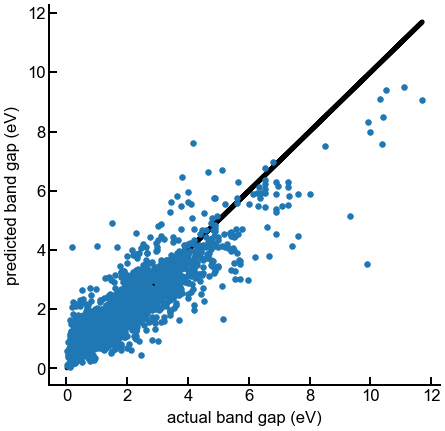

In [4]:
# Load the data and construct the arrays
df = pd.read_csv('../../assets/data/band_gap_featurized.csv')
display(df.head())
X = df.loc[:, 'MagpieData mean Number':]
y = df['gap expt']

# Train the model and perform CV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
y_hat = cross_val_predict(rf, X, y, cv=kfold)

# Plot the parity plot
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(y, y_hat, s=30)
ax.plot(y, y, 'k', zorder=-5)
ax.set(xlabel='actual band gap (eV)', ylabel='predicted band gap (eV)')
plt.show()

The predictions still aren't perfect (band gap is a hard problem!), but they're better than our linear regression model.

### Feature importance

One of the cool aspects of random forests is that we can calculate the **importance score of each feature** that measures a degree of its "influence" on predicting the output property.
The importance scores will be normalized to sum to `1.0`, and you can read more online about exactly how these scores are calculated, if you want.
The code below will do this for the band gap prediction problem up above and rank the features in order of importance.

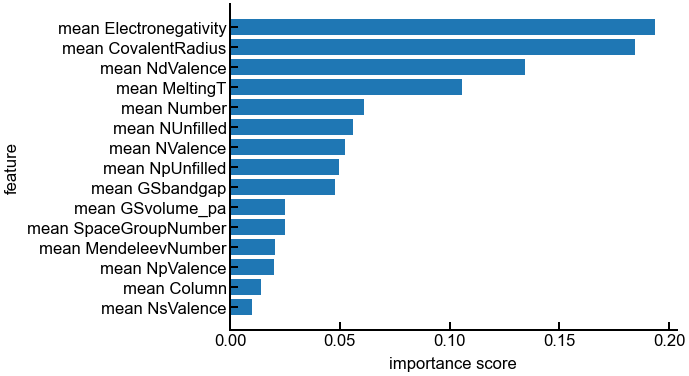

In [5]:
rf.fit(X, y)                                              # we have to explicitly fit the model first
features = np.array([s[11:] for s in X.columns])          # remove the "MagpieData " prefix
importances = rf.feature_importances_                     # get the importances from the attribute
importances_sorted = sorted(importances, reverse=False)   # sort importances, ascending for plotting quirk
indices_sorted = np.argsort(importances)                  # get the indices for indexing into features
features_sorted = features[indices_sorted]                # sort the features too for labeling the plot

# create the bar chart for importance scores in ranked order
yvals = np.arange(len(indices_sorted))    # bar/tick positions
fig, ax = plt.subplots()
ax.barh(yvals, importances_sorted)
ax.set(yticks=yvals, yticklabels=features_sorted, ylabel='feature', xlabel='importance score')
plt.show()

**Pause and reflect**: Can you rationalize the feature importances above?



### Don't say it... don't say it...

With many caveats, random forests are _one of the best "out of the box" ML algorithms_.
They work very well on a wide variety of regression and classification problems without the need for too much hyperparameter optimization and are interpretable (e.g., feature importance).
Like linear regression, this is a good model to use as a "benchmark" before trying other, more complex models.
With scikit-learn, building a random forest follows the same sequence of steps as linear regression!

<div class="alert alert-block alert-warning">
    <center><b>~ BREAK ~</b></center>
    At this point, we highly suggest you give yourself a decent break before continuing further. 🥰
    Get a drink of water, go grab a bite, or at least stand up and stretch to give your eyes a break.
    You all are awesome!! 🙌
</div>

## Unsupervised learning

[Back to top](#Contents)

Up until this point, we've only looked at supervised learning algorithms, where the algorithm must be given the inputs $X$ and outputs $\vec{y}$ to fit some parameters $\vec{\theta}$.
Now we will launch into a short discussion of **unsupervised learning** algorithms, where the algorithm is only given the [same] input design matrix $X$, _but not the output target vector_ $\vec{y}$.
We'll discuss some concrete examples of such algorithms and why we might want to use them.

### Goals of unsupervised learning

After reading the above, one might think, "Well, if an unsupervised learning algorithm is provided even less information than a supervised learning algorithm, wouldn't it necessarily be less powerful?"
This would be true if the algorithms were trying to achieve the same goal, but since they aren't, unsupervised learning algorithms can still be very useful.

Recall in supervised learning, we're trying to figure out how to map a set of inputs in $X$ to an output $\vec{y}$ as accurately as possible.
In unsupervised learning, we're no longer concerned about any target property/label, but rather we're curious about the **inherent structure** in the data, such as whether there are clusters or trends along certain features.
The goal always comes first, then the algorithms (which scientists decided to name this way)—not the other way around.

## $k$-means clustering

[Back to top](#Contents)

Since one of the goals of unsupervised learning is to reveal clusters in your data, let's discuss one of the simplest algorithms to achieve this goal: $k$**-means**.
The intuition behind this algorithm is to find $k$ cluster centers, or **centroids**, such that all data points that are closest to the same centroid are assigned the same cluster.
Note that when we say two data points belong to the same cluster, we're **not** saying they have the same class/label (like in classification problems), but rather that they are near each other _in feature space_.

$k$-means is an **iterative algorithm** consisting of two steps:

0. First, at the very beginning, the user initializes $k$ centroids by their choosing, either randomly or [intelligently](https://en.wikipedia.org/wiki/K-means++).
1. **Assignment step**: For each _data point_, assign it to the closest centroid by Euclidean distance.
2. **Update step**: For each _centroid_, recalculate its position to be the centroid of all the data points that were assigned to it in the previous step.
3. Repeat steps **1** and **2** until the centroids converge.

To illustrate how this algorithm works, we provide an implementation below where we perform $k$-means manually.
The data are points in 2D space randomly scattered around three centers and we use a star ★ to represent the centroid. 
The points are colored based on the current centroid (cluster) they're assigned to, and you can see them change color (clusters) as the algorithm progresses and as the centroids update.

In [6]:
# assignment step
def assign(points, centroids, clusters):
    for j, p in enumerate(points):
        dist = np.linalg.norm(centroids - p, axis=1)   # calculate distance between p and each centroid
        clusters[j] = np.argmin(dist)                  # reassign the point to the nearest centroid (cluster)
    return clusters

# update step
def update(points, centroids, clusters):
    for i in range(k):
        id_mask = clusters == i                           # find which points belong to the ith cluster
        centroids[i] = np.mean(points[id_mask], axis=0)   # recalculate the centroid based on currently-assigned data points
    return centroids

In [7]:
from matplotlib.animation import FuncAnimation

# load in data and initialize clusters array
points = np.load('../../assets/data/kmeans_data.npy')
clusters = np.zeros(len(points), dtype=int)

# initialize 3 centroids randomly
k = 3
rng = np.random.default_rng(seed=1)
centroids = rng.choice(np.arange(2 * k, dtype=float), size=(k, 2))
clusters = assign(points, centroids, clusters)

# plotting boilerplate
fig, ax = plt.subplots(figsize=(6, 4))
h = ax.scatter([], [])
j = ax.scatter([], [])
ax.set_aspect('equal')
plt.tight_layout()
plt.close()

def init():
    return h, j,

def animate(kk):
    global points, centroids, clusters, h, j
    clusters = assign(points, centroids, clusters)
    h.remove()
    h = ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c=[f'C{i}' for i in range(k)])
    j.remove()
    j = ax.scatter(points[:, 0], points[:, 1], c=[f'C{i}' for i in clusters], alpha=0.4)
    centroids = update(points, centroids, clusters)
    return h, j,

plt.rcParams.update({'animation.html': 'jshtml', 'font.size':12})
anim = FuncAnimation(fig, animate, init_func=init, frames=5, interval=100, repeat=False)
anim

OK, so that was a toy example just to illustrate how the algorithm works (repeating the assign-update steps) so you can understand how the clusters are assigned in higher dimensions.
While this is a fairly intuitive way to identify clusters in your data, there are [a few issues](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages) with $k$-means, including:
- Has poor performance in higher dimensions (if there are a lot of features)
- Sensitive on the initial choice of cluster centroids.
- User must manually choose the value of $k$ (for example, the algorithm inherently does not know the above data is in three clusters).

### Using KMeans from scikit-learn

With the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class in scikit-learn, we can automate a lot of the previous code we wrote.
You can read online ([such as this blog](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)) for ways to determine the optimal $k$ value.
There are also [many more clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) in scikit-learn besides $k$-means.

**NOTE**: The following code may not work due to an incompatibility with scikit-learn and OpenBLAS. 🙃

In [12]:
from sklearn.cluster import KMeans

points = np.load('../../assets/data/kmeans_data.npy')
k = 3
kmeans = KMeans(n_clusters=k)       # initialize the model and k value
kmeans.fit(points)                  # do the iterative steps to finalize centroids
clusters = kmeans.predict(points)   # this predicts the cluster labels, not an output property!
centers = kmeans.cluster_centers_   # get the final centroids

fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], c=[f'C{i}' for i in clusters], alpha=0.4)
ax.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c=[f'C{i}' for i in range(k)])
ax.set_aspect('equal')
plt.show()

KMeans(n_clusters=3)

KMeans(n_clusters=3)

AttributeError: 'NoneType' object has no attribute 'split'

## Dimensionality reduction

[Back to top](#Contents)

In addition to clustering, unsupervised learning is commonly used for **dimensionality reduction** to simplify the representation of your data in a lower dimensional space.
What do we mean by "dimension?"
Let's say your data (design matrix) looks like:

$$ X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} & x_3^{(1)} \\ 
                       x_1^{(2)} & x_2^{(2)} & x_3^{(2)} \\ 
                       \vdots & \vdots & \vdots \\
                       x_1^{(m)} & x_2^{(m)} & x_3^{(m)} \end{bmatrix} $$
                       
where each data point (row) has three features that could conceivably be coordinates in 3D space.
Therefore, we might say that the data in $X$ "lives in 3 dimensions."
Analogously, when we have a design matrix with $n$ features, we say the data lives in $n$-dimensional space.
Since $n$-dimensional space is complicated and hard to visualize for $n > 3$ (or $n > 2$, really), we would like to see if there is a way to **project** our data into 2D **while preserving the structure** of the data in the original $n$-dimensional space.

### Principal component analysis (PCA)

As you might expect, there are many ways to do this projection, ultimately boiling down to whether the projection is done linearly or nonlinearly.
One type of **linear projection** is **principal components analysis (PCA)**, which projects your data onto the subspace spanned by the principal components (PCs), which are orthogonal vectors pointing in the directions of **greatest variance**.
As an example, if you have a cloud of points in 3D shaped like a football, then the first principal component (direction of greatest variance) points from the center of the football towards one of the ends.
The second principal component then points from the center out towards the bulging side.

PCA is a very common dimensionality reduction technique to help visualize high-dimensional datasets in 2D.
Once you calculate the lower-dimensional representation, you can perform other calculations such as [$k$-means clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html), [regression](https://www.statology.org/principal-components-regression/), and more.
While scikit-learn has a [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) package, we will leave it up to you to read more about it as we don't want to overload you with code and can't come up with a good motivating example.
If you are interested in this for your research, let us know and we'd be happy to chat.

### _t_-distributed stochastic neighbor embedding (t-SNE)

One of the most popular forms of **nonlinear** dimensionality reduction is the _t_-distributed stochastic neighbor embedding algorithm, or **t-SNE**, which has the potential to generate very pretty and surprisingly visualizations.
The motivation behind this algorithm is one that tries to preserve spatial similarity, such that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points.
t-SNE plots are tricky to make because they're **very sensitive to hyperparameter optimization**, as described in [this Distill post](https://distill.pub/2016/misread-tsne/).
Scikit-learn has an implementation in their [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) package, and we invite you to read the documentation if you want to learn more.

## Conclusion

[Back to top](#Contents)

This concludes the bonus content on advanced ML models.

If you have any questions, please do not hesitate to ask on Slack!